### Test different optimizers in GPytorch on fake data 

We will try to reconstruct a sine wave with scattered data.
Something similar to : https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
The ultimate goal is to see if a quasi-newton optimizer works. 

In [1]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import sys
sys.path.append('../../../python_packages/PyTorch-LBFGS/functions/')
from LBFGS import FullBatchLBFGS

In [3]:
np.random.seed(1234);
xr.set_options(display_style='html');

In [4]:
def fake_1d_data(n_samples, rangex=1, k=2*np.pi, eta=1): 
    
    x = rangex*np.random.rand(n_samples)
    
    x = xr.DataArray(x, dims=['sample_num'],
                    coords=[range(n_samples)])
    
    yerr = eta* np.random.randn(n_samples)
    
    y = np.sin(k*x) + yerr
    
    return x, y

In [25]:
# Generate a fake data set at some random sample points.
eta = 0.2
rangex=30 
k= 1

[x,y] = fake_1d_data(50, rangex, k, eta)

Text(0, 0.5, 'y')

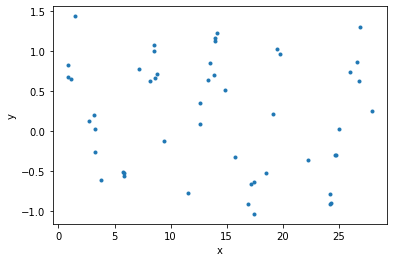

In [26]:
plt.plot(x,y,'.')
plt.xlabel('x')
plt.ylabel('y')

In [27]:
# convert to torch tensors, since that is what PyTorch and GPyTorch work with.
train_x = torch.from_numpy(x.values).float()
train_y = torch.from_numpy(y.values).float()

In [28]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.RBFKernel(ard_num_dims=1, 
                                                       has_lengthscale=True))#train_x.shape[1])) 
                                        #,lengthscale_prior=[0.5, 0.5, 0.5]))

        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [29]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPModel(train_x, train_y, likelihood)

In [30]:
# Find optimal model hyperparameters
model.train() 
likelihood.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer

#optimizer = torch.optim.Adam([
#                {'params': model.parameters()},  # Includes GaussianLikelihood parameters
#                              ], lr=0.1) # set learning rate of 0.1
optimizer = FullBatchLBFGS(model.parameters())

In [31]:
# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [32]:
# define closure
def closure():
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    return loss

In [33]:
loss = closure()
loss.backward()

In [34]:
training_iter = 10
for i in range(training_iter):

    # perform step and update curvature
    options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
    loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(options)

#    print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f noise: %.3f' % (
#            i + 1, training_iter, loss.item(),
#            model.covar_module.base_kernel.lengthscale[0][0].item(),
#            model.likelihood.noise.item()
#              ))
    
    print('Iter %d/%d - Loss: %.3f - LR: %.3f - Func Evals: %0.0f - Grad Evals: %0.0f - Log-Lengthscale: %.3f - Log_Noise: %.3f' % (
        i + 1, training_iter, loss.item(), lr, F_eval, G_eval,
        model.covar_module.base_kernel.lengthscale[0][0].item(),
        model.likelihood.noise.item()
        ))

Iter 1/10 - Loss: 0.647 - LR: 8.000 - Func Evals: 4 - Grad Evals: 4 - Log-Lengthscale: 0.891 - Log_Noise: 0.152
Iter 2/10 - Loss: 0.493 - LR: 0.097 - Func Evals: 3 - Grad Evals: 1 - Log-Lengthscale: 1.053 - Log_Noise: 0.057
Iter 3/10 - Loss: 0.475 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.266 - Log_Noise: 0.039
Iter 4/10 - Loss: 0.465 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.224 - Log_Noise: 0.051
Iter 5/10 - Loss: 0.462 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.267 - Log_Noise: 0.049
Iter 6/10 - Loss: 0.460 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.343 - Log_Noise: 0.048
Iter 7/10 - Loss: 0.459 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.398 - Log_Noise: 0.047
Iter 8/10 - Loss: 0.459 - LR: 0.360 - Func Evals: 2 - Grad Evals: 1 - Log-Lengthscale: 1.424 - Log_Noise: 0.048
Iter 9/10 - Loss: 0.459 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 1.429 - Log_Noise

In [35]:
print('Noise std: ', model.likelihood.noise_covar.noise.item()**0.5)
print('Scale kernel: ',model.covar_module.outputscale.item())
print('Length/time scales: ',model.covar_module.base_kernel.lengthscale)

Noise std:  0.21944966989461095
Scale kernel:  0.6628506779670715
Length/time scales:  tensor([[1.4306]], grad_fn=<SoftplusBackward>)


In [36]:
test_pts = torch.from_numpy(
            np.array(np.linspace(-10,rangex+10,500))).float()

In [37]:
test_pts_xr = xr.DataArray(test_pts.numpy(),  dims=["test_pt_num"], 
                        coords=[range(test_pts.shape[0])] ) 

In [38]:
# Get into evaluation (predictive posterior) mode
# this is the specific way that PyTorch works, basically sort
# of like freezing parameters, stop tracking gradients.
model.eval()
likelihood.eval();

In [39]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_pts))

In [40]:
mean_obs = observed_pred.mean
var_obs  = observed_pred.variance
samp1    = observed_pred.sample()
# still takes time. but still much faster. :) 

In [41]:
lower, upper = observed_pred.confidence_region()

In [42]:
pred_mean = xr.DataArray(mean_obs.numpy(),  dims={"test_pt_num"})
pred_var = xr.DataArray(var_obs.detach().numpy(),  dims={"test_pt_num"})
pred_samp = xr.DataArray(samp1.numpy(),  dims={"test_pt_num"})

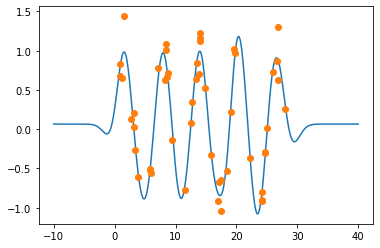

In [43]:
plt.plot(test_pts_xr, pred_mean)
plt.plot(x,y,'o')


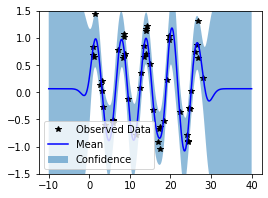

In [44]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_pts.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_pts.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1.5, 1.5])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])